attack_category
Benign                 562335
Background             170151
Probing                 23388
Bruteforce-XML           8795
Bruteforce               7988
XMRIGCC CryptoMiner      7595
Name: count, dtype: int64


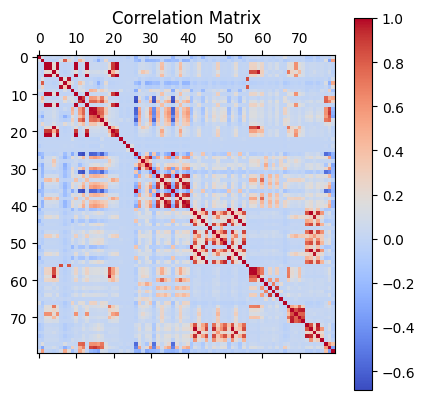

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

df1 = pd.read_csv('ALLFLOWMETER_HIKARI2022.csv')
df2 = pd.read_csv('ALLFLOWMETER_HIKARI2021.csv')

df1.drop('bwd_last_window_size', axis=1, inplace=True)

# Combining two IDS datasets acquired over 2 years to develop good model
combined_df = pd.concat([df1, df2], ignore_index=True)

# we remove the 'flow_duration' here too because it has no real impact on the analysis and the formats are very different from same
# synthetic dataset reproduced as shown in paper.
combined_df.drop(['Unnamed: 0', 'uid', 'flow_duration'], axis=1, inplace=True)

combined_df['attack_category'] = combined_df['attack_category'].str.strip()
# Replacing similar values with correct version
combined_df['attack_category']=combined_df['attack_category'].replace('Brutefoce', 'Bruteforce')

attack_category_counts = combined_df['attack_category'].value_counts()
print(attack_category_counts)

y = combined_df['attack_category']

combined_df = combined_df.drop(['attack_category', 'Label', 'originh', 'responh'], axis=1)
X = combined_df
correlation_matrix = combined_df.corr()


plt.matshow(correlation_matrix, cmap='coolwarm')
plt.colorbar()
plt.title('Correlation Matrix')
plt.show()


In [31]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

# Names of columns with missing values
cols_with_missing_values = [col for col in X_train.columns
                            if X_train[col].isnull().any()]

print(cols_with_missing_values)
# With prelimnary analysis we found that there were no missing values in any 
# of the columns. Hence, it is a robust dataset.

rfc_model = RandomForestClassifier(n_estimators=500, random_state=0)
rfc_model.fit(X_train, y_train)

[]


RandomForestClassifier(n_estimators=500, random_state=0)

In [33]:
predictions = rfc_model.predict(X_valid)

accuracy = accuracy_score(y_valid, predictions)

print("Accuracy: ", accuracy)
print("Classification Report:")
print(classification_report(y_valid, predictions))

Accuracy:  0.8034745051297332
Classification Report:
                     precision    recall  f1-score   support

         Background       0.76      0.71      0.73     34047
             Benign       0.86      0.88      0.87    112584
         Bruteforce       0.36      0.37      0.36      1579
     Bruteforce-XML       0.46      0.49      0.47      1704
            Probing       0.02      0.01      0.02      4607
XMRIGCC CryptoMiner       0.49      0.40      0.44      1530

           accuracy                           0.80    156051
          macro avg       0.49      0.48      0.48    156051
       weighted avg       0.80      0.80      0.80    156051



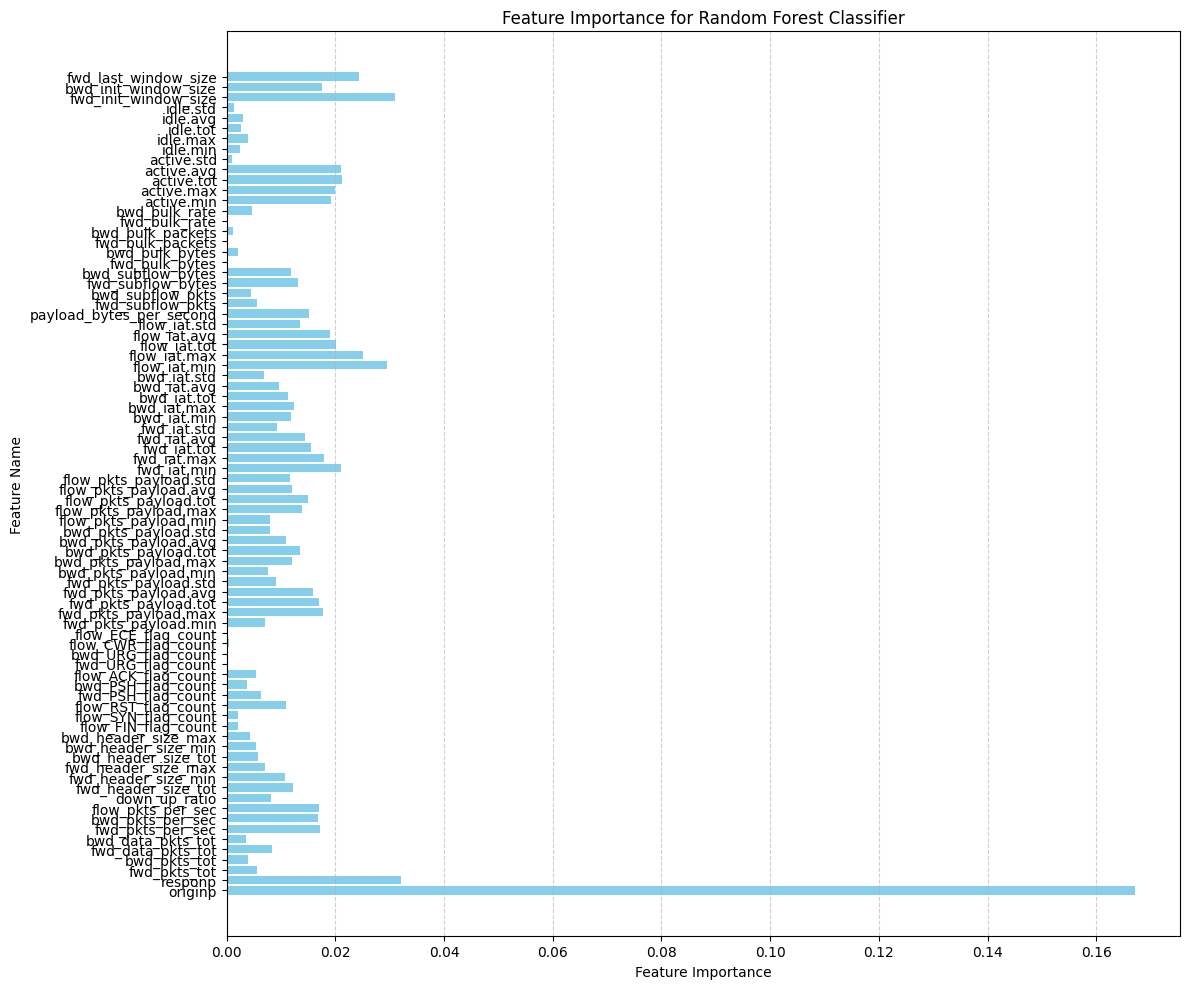

In [34]:
feature_importances = rfc_model.feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(12,10))
plt.barh(feature_names, feature_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance for Random Forest Classifier")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

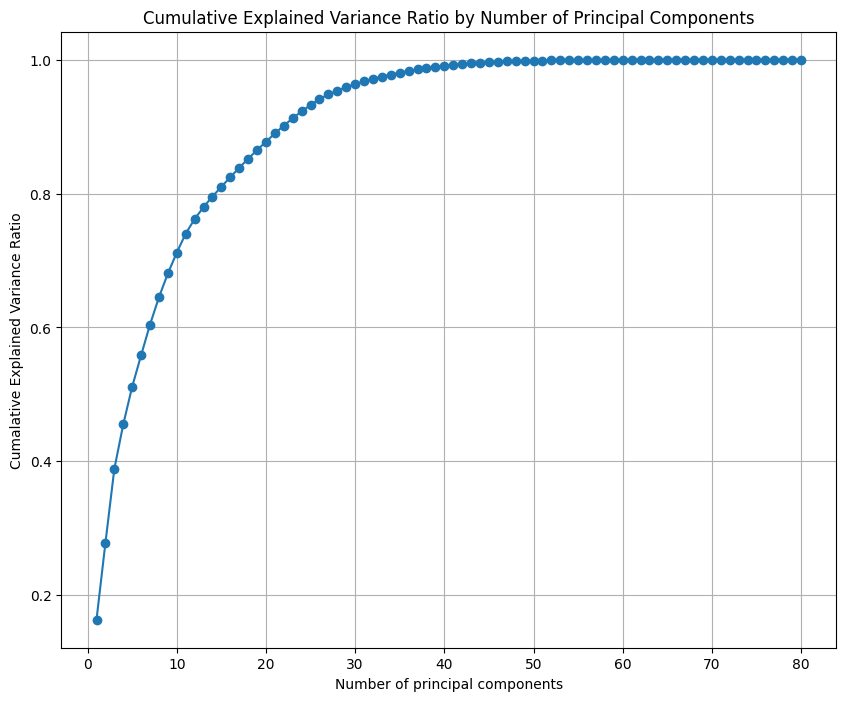

In [36]:
# Using Principal Component Analysis to do further feature analysis

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_train)

pca = PCA()
principal_components = pca.fit_transform(scaled_data)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10,8))
plt.plot(range(1, len(explained_variance_ratio)+1), cumulative_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Number of principal components')
plt.ylabel('Cumalative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio by Number of Principal Components')
plt.grid(True)
plt.show()


TOP 30 Features:
Index(['bwd_pkts_payload.tot', 'flow_pkts_payload.tot', 'fwd_iat.min',
       'fwd_iat.max', 'fwd_iat.tot', 'fwd_iat.avg', 'fwd_iat.std',
       'bwd_iat.max', 'bwd_iat.tot', 'bwd_iat.avg', 'bwd_iat.std',
       'flow_iat.min', 'flow_iat.max', 'flow_iat.tot', 'flow_iat.avg',
       'flow_iat.std', 'payload_bytes_per_second', 'bwd_subflow_bytes',
       'bwd_bulk_rate', 'active.min', 'active.max', 'active.tot', 'active.avg',
       'active.std', 'idle.min', 'idle.max', 'idle.tot', 'idle.avg',
       'idle.std', 'bwd_init_window_size'],
      dtype='object')


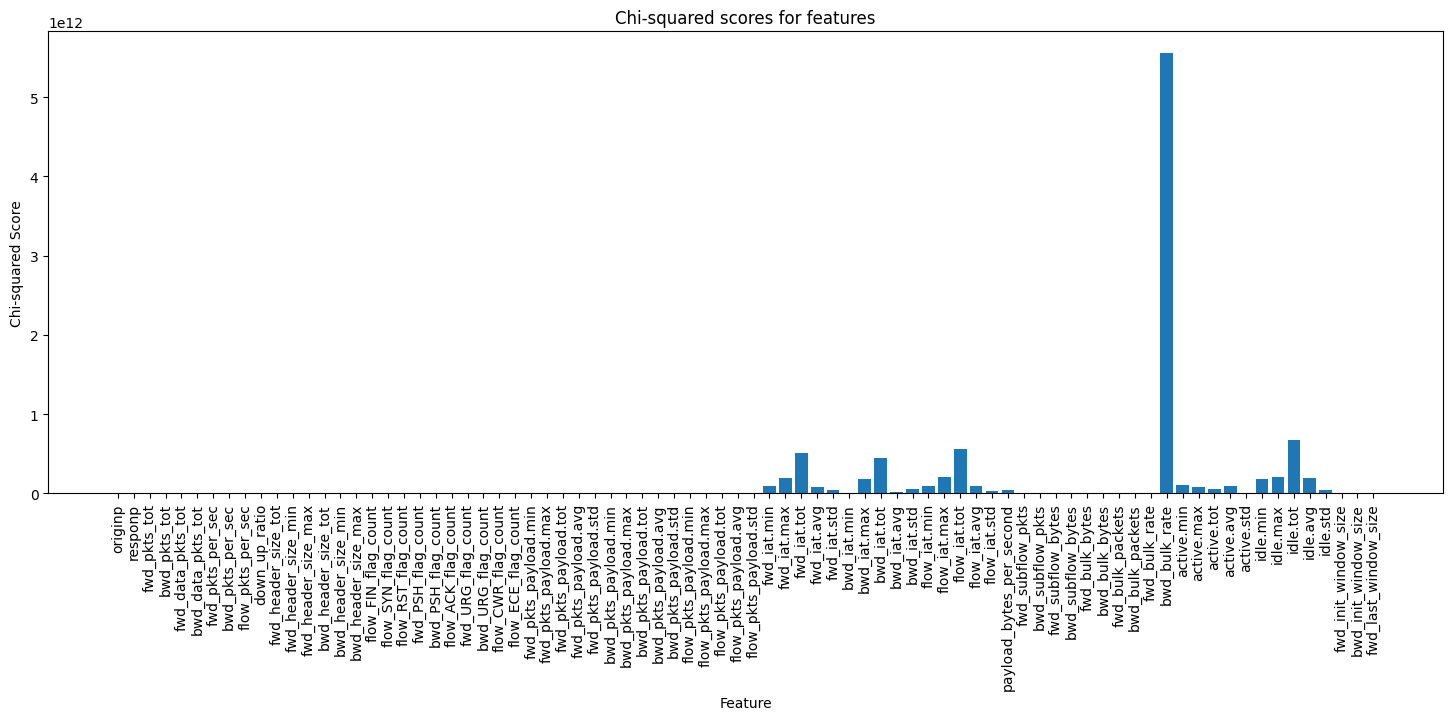

In [48]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

k = 30

selector = SelectKBest(score_func=chi2, k=k)

selector.fit(X_train, y_train)
top_feature_indices = selector.get_support(indices=True)
top_feature_names = X_train.columns[top_feature_indices]
print("TOP", k, "Features:")
print(top_feature_names)
chi2_scores = selector.scores_

all_feature_names = X_train.columns

plt.figure(figsize=(18,6))
plt.bar(range(len(all_feature_names)), chi2_scores, tick_label=all_feature_names)
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Chi-squared Score')
plt.title('Chi-squared scores for features')
plt.show()

In [54]:
top_features = ['fwd_iat.min','fwd_iat.max', 'fwd_iat.tot', 'fwd_iat.avg', 'fwd_iat.std',
       'bwd_iat.max', 'bwd_iat.tot', 'bwd_iat.avg', 'bwd_iat.std',
       'flow_iat.min', 'flow_iat.max', 'flow_iat.tot', 'flow_iat.avg',
       'flow_iat.std', 'payload_bytes_per_second',
       'bwd_bulk_rate', 'active.min', 'active.max', 'active.tot', 'active.avg',
       'active.std', 'idle.min', 'idle.max', 'idle.tot', 'idle.avg',
       'idle.std']
df1 = pd.read_csv('ALLFLOWMETER_HIKARI2022.csv')
df2 = pd.read_csv('ALLFLOWMETER_HIKARI2021.csv')

df1.drop('bwd_last_window_size', axis=1, inplace=True)

# Combining two IDS datasets acquired over 2 years to develop good model
combined_df = pd.concat([df1, df2], ignore_index=True)

# we remove the 'flow_duration' here too because it has no real impact on the analysis and the formats are very different from same
# synthetic dataset reproduced as shown in paper.
combined_df.drop(['Unnamed: 0', 'uid', 'flow_duration'], axis=1, inplace=True)

combined_df['attack_category'] = combined_df['attack_category'].str.strip()
# Replacing similar values with correct version
combined_df['attack_category']=combined_df['attack_category'].replace('Brutefoce', 'Bruteforce')
y = combined_df['attack_category']
X = combined_df[top_features]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)


Number of rows in combined_df: 780252


In [56]:
rfc_model = RandomForestClassifier(n_estimators=200, random_state=0)
rfc_model.fit(X_train, y_train)
predictions = rfc_model.predict(X_valid)

accuracy = accuracy_score(y_valid, predictions)

print("Accuracy: ", accuracy)
print("Classification Report:")
print(classification_report(y_valid, predictions))

Accuracy:  0.7750863499753285
Classification Report:
                     precision    recall  f1-score   support

         Background       0.73      0.57      0.64     34047
             Benign       0.82      0.88      0.85    112584
         Bruteforce       0.36      0.37      0.36      1579
     Bruteforce-XML       0.46      0.47      0.47      1704
            Probing       0.01      0.01      0.01      4607
XMRIGCC CryptoMiner       0.72      0.35      0.47      1530

           accuracy                           0.78    156051
          macro avg       0.52      0.44      0.47    156051
       weighted avg       0.77      0.78      0.77    156051



In [ ]:
print("hello")